# Quick Start

This quick start will show how to do the following:

- `Install` everything needed to use pyGAM.
- `fit a model` with custom terms
- search for the `best smoothing parameters`
- plot `partial dependence` functions


## Install pyGAM
#### Pip

    pip install pygam


#### Conda
pyGAM is on conda-forge, however this is typically less up-to-date:

    conda install -c conda-forge pygam
    

#### Bleeding edge
You can install the bleeding edge from github using `flit`.
First clone the repo, ``cd`` into the main directory and do:

    pip install flit
    flit install

### Get `pandas` and `matplotlib`

    pip install pandas matplotlib



## Fit a Model
First we need some data

In [1]:
from pygam.datasets import wage

X, y = wage()

/home/dswah/miniconda3/envs/pygam36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


Now let's import a GAM that's made for regression problems.

Let's fit a spline term to the first 2 features, and a factor term to the 3rd feature.

In [2]:
from pygam import LinearGAM, s, f

gam = LinearGAM(s(0) + s(1) + f(2)).fit(X, y)

Let's take a look at the model fit:

In [3]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     25.1911
Link Function:                     IdentityLink Log Likelihood:                                -24118.6847
Number of Samples:                         3000 AIC:                                            48289.7516
                                                AICc:                                           48290.2307
                                                GCV:                                             1255.6902
                                                Scale:                                           1236.7251
                                                Pseudo R-Squared:                                   0.2955
Feature Function                  Lam

Even though we have 3 terms with a total of `(20 + 20 + 5) = 45` free variables, the default smoothing penalty (`lam=0.6`) reduces the effective degrees of freedom to just ~25.

## Automatically selecting the best amount of Smoothing

The summary reveals that our model has 3 smoothing parameters, currently one per term.

Let's perform a grid-search to see if we can improve our model.  
We will seek the model with the lowest generalized cross-validation (GCV) score.

Our search space is 3-dimensional, so we have to be conservative with the number of points we consider per dimension.

Let's try 5 values for each smoothing parameters, resulting in a total of `5*5*5 = 125` points in our grid.

In [4]:
import numpy as np

lam = np.logspace(-3, 3, 5)
lams = [lam] * 3

gam.gridsearch(X, y, lam=lams)
gam.summary()

100% (125 of 125) |######################| Elapsed Time: 0:00:08 Time:  0:00:08


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     12.1552
Link Function:                     IdentityLink Log Likelihood:                                -24119.5707
Number of Samples:                         3000 AIC:                                            48265.4518
                                                AICc:                                           48265.5765
                                                GCV:                                             1246.1735
                                                Scale:                                           1237.0883
                                                Pseudo R-Squared:                                   0.2922
Feature Function                  Lam

This is quite a bit better. Even though the $R^2$ value is lower, we can expect our model to generalize better because the GCV error is lower.

For high-dimensional search-spaces, it is sometimes a good idea to try a **randomized search**.  
We can acheive this by using numpy's `random` module:

In [5]:
lams = np.random.rand(100, 3) # random points on [0, 1], with shape (100, 3)
lams = lams * 6 - 3 # shift values to -3, 3
lams = np.exp(lams) # transforms values to 1e-3, 1e3

In [6]:
random_gam =  LinearGAM(s(0) + s(1) + f(2)).gridsearch(X, y, lam=lams)
random_gam.summary()

100% (100 of 100) |######################| Elapsed Time: 0:00:06 Time:  0:00:06


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     19.2181
Link Function:                     IdentityLink Log Likelihood:                                -24115.6855
Number of Samples:                         3000 AIC:                                            48271.8073
                                                AICc:                                           48272.0953
                                                GCV:                                             1249.8918
                                                Scale:                                           1235.4877
                                                Pseudo R-Squared:                                   0.2948
Feature Function                  Lam

In this case, our deterministic search found a better model:

In [7]:
gam.statistics_['GCV'] < random_gam.statistics_['GCV']

True

The `statistics_` attribute is populated after the model has been fitted.
There are lots of interesting model statistics to check out, although many are automatically reported in the model summary:

In [8]:
list(gam.statistics_.keys())

['n_samples',
 'm_features',
 'edof_per_coef',
 'edof',
 'scale',
 'cov',
 'se',
 'AIC',
 'AICc',
 'pseudo_r2',
 'GCV',
 'UBRE',
 'loglikelihood',
 'deviance',
 'p_values']

## Partial Dependence Functions

One of the most attractive properties of GAMs is that we can decompose and inspect the contribution of each feature to the overall prediction. 

This is done via **partial dependence** functions.

Let's plot the partial dependence for each term in our model, along with a 95% confidence interval for the estimated function.

In [9]:
import matplotlib.pyplot as plt

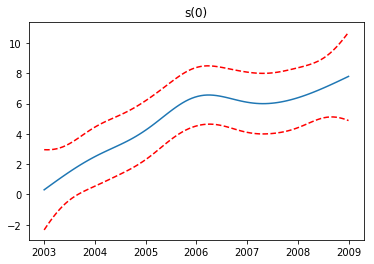

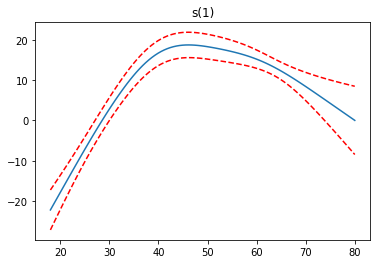

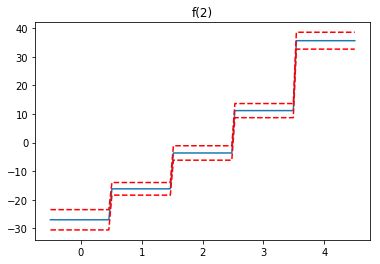

In [10]:
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue
        
    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)
    
    plt.figure()
    plt.plot(XX[:, term.feature], pdep)
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')
    plt.title(repr(term))
    plt.show()

Note: we skip the intercept term because it has nothing interesting to plot.